In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\karna\AppData\Local\Temp\ipykernel_5316\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

In [33]:
data = pd.read_csv('data/cleaned_5272.csv')

In [34]:
data.head()

pl_name  hostname  sy_snum  sy_pnum  discoverymethod  disc_year  \
0    11 Com b    11 Com        2        1  Radial Velocity       2007   
1    11 UMi b    11 UMi        1        1  Radial Velocity       2009   
2    14 And b    14 And        1        1  Radial Velocity       2008   
3    14 Her b    14 Her        1        2  Radial Velocity       2002   
4  16 Cyg B b  16 Cyg B        3        1  Radial Velocity       1996   

     pl_orbper  pl_orbeccen  pl_orbsmax  pl_rade   pl_bmasse  pl_insol  \
0   326.030000     0.231000    1.290000      NaN  6165.60000       NaN   
1   516.219970     0.080000    1.530000      NaN  4684.81420       NaN   
2   185.840000     0.000000    0.830000      NaN  1525.50000       NaN   
3  1765.038901     0.372689    2.773069      NaN  2586.74645       NaN   
4   798.500000     0.680000    1.660000      NaN   565.73740       NaN   

   pl_eqt st_spectype  st_teff  st_rad  st_mass  st_met st_metratio  st_logg  \
0     NaN      G8 III   4742.0   19.00     2.70   -0.35      [Fe/H]     2.31   
1     NaN         NaN   4213.0   29.79     2.78   -0.02      [Fe/H]     1.93   
2     NaN      K0 III   4813.0   11.00     2.20   -0.24      [Fe/H]     2.63   
3     NaN         NaN      NaN     NaN     0.91     NaN         NaN      NaN   
4     NaN         NaN   5750.0    1.13     1.08    0.06      [Fe/H]     4.36   

    sy_dist planet_type  
0   93.1846   Gas Giant  
1  125.3210   Gas Giant  
2   75.4392   Gas Giant  
3   17.9323   Gas Giant  
4   21.1397   Gas Giant

# Pre-Processing

### Choose features

* Categorical Variables are ignored as they aren't suitable for k-means.
* Some continuous variables like pl_insol, pl_eqt, p_orbeccen are removed as they have more than 60% data as NA. Can impute, but the values will be inflated.

In [35]:
features = ['pl_orbper','pl_orbsmax','pl_rade','pl_bmasse','st_teff','st_rad','st_mass','st_met','st_logg','sy_dist','planet_type'] 

In [36]:
cluster_data = data.loc[:,features].dropna()
cluster_data.shape

(648, 11)

In [37]:
cluster_data.head()

pl_orbper  pl_orbsmax  pl_rade   pl_bmasse  st_teff  st_rad  st_mass  \
30  7.365474e-01     0.01544    1.875     7.99000   5172.0    0.94     0.91   
77  4.020000e+08  7506.00000   12.442  2002.31896   3406.0    0.39     0.37   
80  1.324060e+01     0.10550   10.870   874.00000   5075.0    0.79     0.89   
81  2.994330e+00     0.04360   16.030   740.51000   6440.0    1.37     1.27   
82  2.828042e+00     0.04016   16.140   291.43800   5675.0    1.12     1.08   

    st_met  st_logg    sy_dist  planet_type  
30    0.35     4.43    12.5855  Super Earth  
77    0.00     4.83    10.8864    Gas Giant  
80    0.26     4.65   338.3860    Gas Giant  
81   -0.03     4.22   655.0370    Gas Giant  
82    0.16     4.38  1126.3700    Gas Giant

### Remove Outliers

In [38]:
z = np.abs(stats.zscore(cluster_data.loc[:,cluster_data.columns!='planet_type']))

cluster_data = cluster_data[(z<3).all(axis=1)]
cluster_data.shape

(605, 11)

In [39]:
cluster_data_X = cluster_data.drop('planet_type',axis=1)
cluster_data_Y = cluster_data['planet_type']

In [40]:
cluster_data_X.describe()

pl_orbper  pl_orbsmax     pl_rade    pl_bmasse      st_teff  \
count   605.000000  605.000000  605.000000   605.000000   605.000000   
mean     22.468717    0.106439    9.131147   273.884891  5397.447934   
std      95.795784    0.215458    5.778027   380.724036   843.068994   
min       0.321962    0.007100    0.510000     0.070000  2850.000000   
25%       2.879232    0.038150    2.870000    12.970000  4985.000000   
50%       4.231306    0.052080   10.760000   139.845200  5570.000000   
75%      10.288910    0.090300   13.585000   349.611250  5978.000000   
max    1107.592300    2.720500   23.371000  2302.899000  7800.000000   

           st_rad     st_mass      st_met     st_logg      sy_dist  
count  605.000000  605.000000  605.000000  605.000000   605.000000  
mean     1.088744    0.977306    0.058170    4.395140   350.196239  
std      0.434068    0.283438    0.195149    0.236841   304.383593  
min      0.160000    0.120000   -0.500000    3.600000     6.531270  
25%      0.790000    0.810000   -0.060000    4.220000   114.173000  
50%      0.990000    0.970000    0.070000    4.410000   275.587000  
75%      1.390000    1.170000    0.200000    4.550000   486.474000  
max      2.590000    1.900000    0.522000    5.130000  1477.980000

### Histograms of chosen data

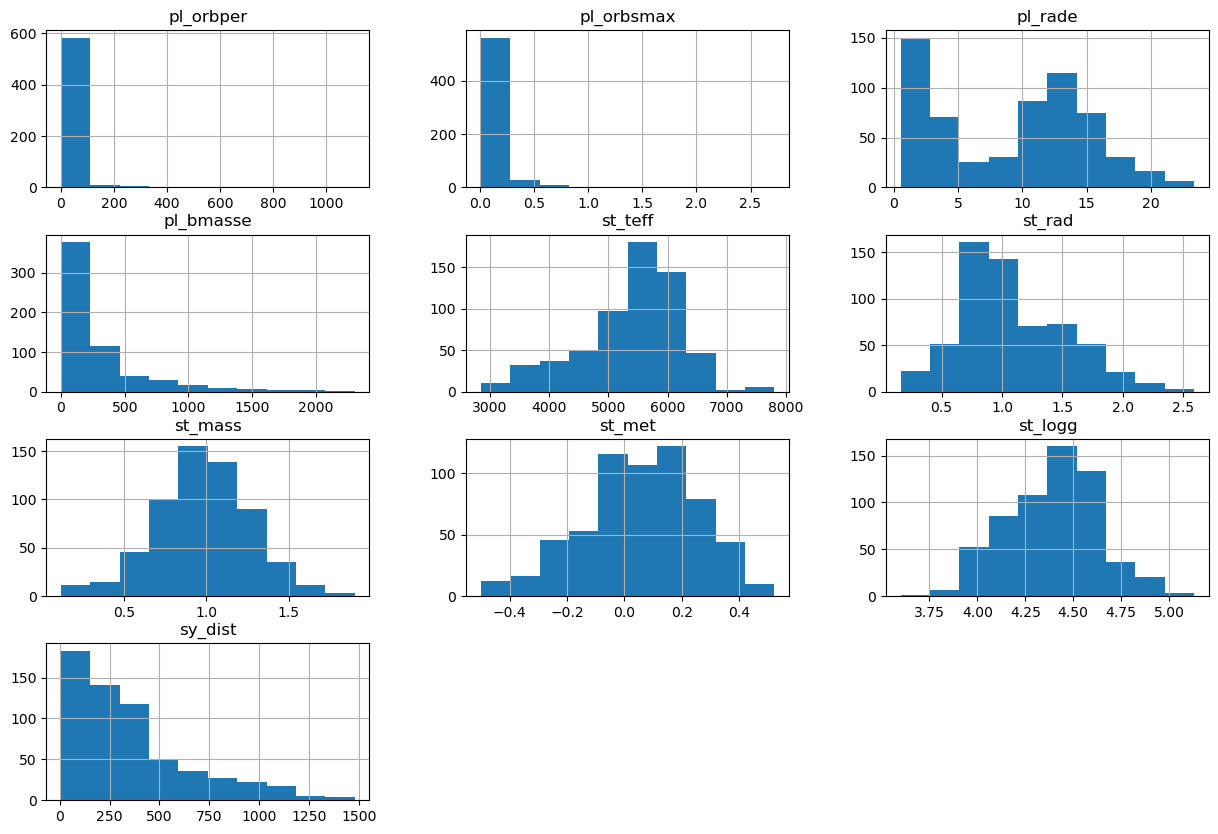

In [41]:
cluster_data_X.hist(bins=10, figsize=(15, 10));

### Histograms after standardizing

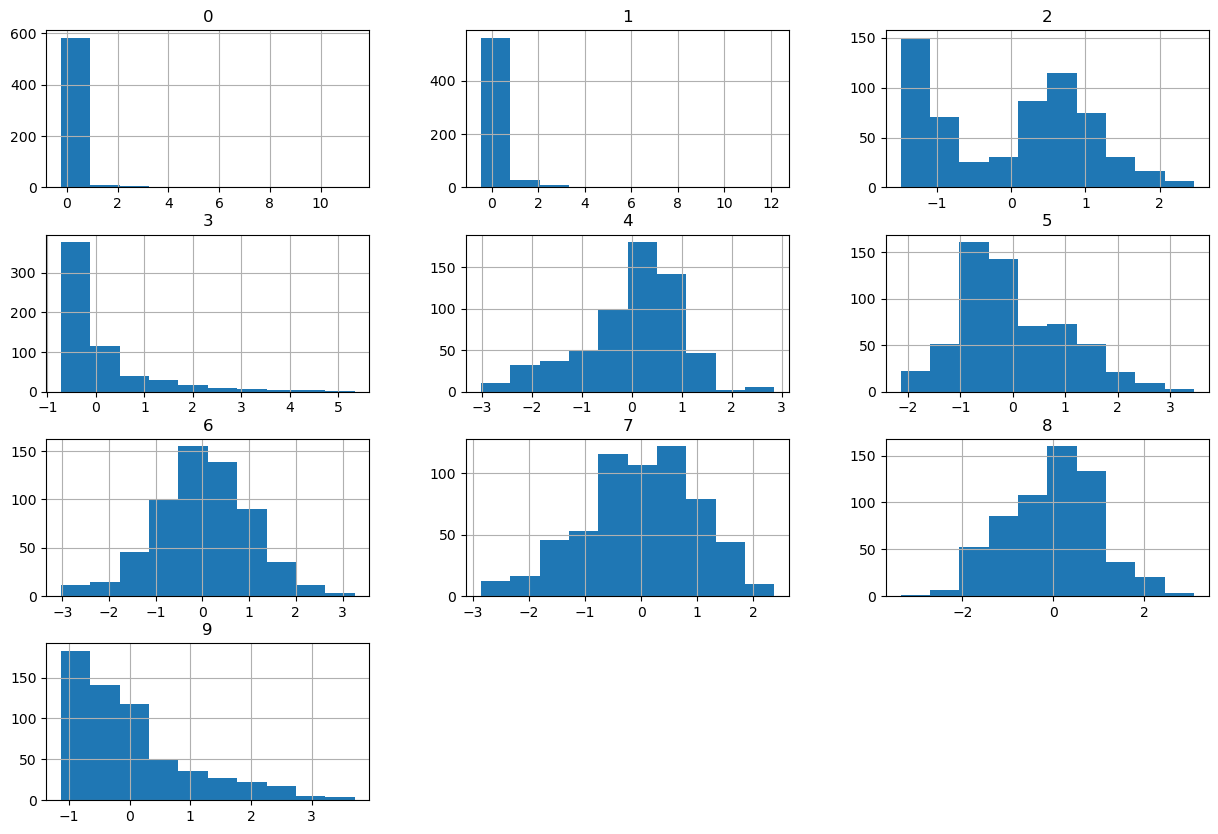

In [42]:
scaler = StandardScaler()
scaled_data_X = pd.DataFrame(scaler.fit_transform(cluster_data_X))
scaled_data_X.hist(bins=10, figsize=(15, 10));

In [43]:
scaled_data_X.describe()

0             1             2             3             4  \
count  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02   
mean   5.156573e-17 -1.005623e-16  4.760196e-16  1.108388e-16  2.385603e-17   
std    1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00   
min   -2.313785e-01 -4.614421e-01 -1.493292e+00 -7.197903e-01 -3.024137e+00   
25%   -2.046614e-01 -3.172110e-01 -1.084510e+00 -6.858794e-01 -4.896269e-01   
50%   -1.905355e-01 -2.525044e-01  2.821379e-01 -3.523565e-01  2.048407e-01   
75%   -1.272487e-01 -7.496775e-02  7.714637e-01  1.990655e-01  6.891873e-01   
max    1.133684e+01  1.214264e+01  2.466523e+00  5.333766e+00  2.852127e+00   

                  5             6             7             8             9  
count  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  
mean  -4.150950e-16  1.108388e-16  4.991416e-17 -3.994234e-15 -4.128929e-18  
std    1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  
min   -2.141398e+00 -3.027167e+00 -2.862592e+00 -3.360047e+00 -1.129986e+00  
25%   -6.888115e-01 -5.907608e-01 -6.060395e-01 -7.400959e-01 -7.760554e-01  
50%   -2.276729e-01 -2.579690e-02  6.066922e-02  6.279220e-02 -2.453187e-01  
75%    6.946044e-01  6.804079e-01  7.273779e-01  6.543940e-01  4.480876e-01  
max    3.461436e+00  3.258056e+00  2.378764e+00  3.105316e+00  3.708206e+00

## Log Transformation of some columns

In [44]:
log_cluster_data_X = cluster_data_X.copy()
log_cluster_data_X['pl_orbper'] = np.log(log_cluster_data_X['pl_orbper'])
log_cluster_data_X['pl_orbsmax'] = np.log(log_cluster_data_X['pl_orbsmax'])
log_cluster_data_X['pl_bmasse'] = np.log(log_cluster_data_X['pl_bmasse'])
log_cluster_data_X['sy_dist'] = np.log(log_cluster_data_X['sy_dist'])

In [45]:
log_cluster_data_X.head()

pl_orbper  pl_orbsmax  pl_rade  pl_bmasse  st_teff  st_rad  st_mass  \
30  -0.305782   -4.170794    1.875   2.078191   5172.0    0.94     0.91   
80   2.583288   -2.249044   10.870   6.773080   5075.0    0.79     0.89   
81   1.096721   -3.132698   16.030   6.607339   6440.0    1.37     1.27   
82   1.039585   -3.214884   16.140   5.674827   5675.0    1.12     1.08   
83   1.395053   -2.975930    9.920   6.029973   5945.0    1.01     1.09   

    st_met  st_logg   sy_dist  
30    0.35     4.43  2.532545  
80    0.26     4.65  5.824187  
81   -0.03     4.22  6.484692  
82    0.16     4.38  7.026755  
83    0.01     4.46  7.046586

In [46]:
log_cluster_data_X.describe()

pl_orbper  pl_orbsmax     pl_rade   pl_bmasse      st_teff  \
count  605.000000  605.000000  605.000000  605.000000   605.000000   
mean     1.772000   -2.773191    9.131147    4.345338  5397.447934   
std      1.232912    0.842846    5.778027    1.961491   843.068994   
min     -1.133322   -4.947660    0.510000   -2.659260  2850.000000   
25%      1.057524   -3.266230    2.870000    2.562639  4985.000000   
50%      1.442511   -2.954974   10.760000    4.940536  5570.000000   
75%      2.331067   -2.404618   13.585000    5.856822  5978.000000   
max      7.009944    1.000816   23.371000    7.741924  7800.000000   

           st_rad     st_mass      st_met     st_logg     sy_dist  
count  605.000000  605.000000  605.000000  605.000000  605.000000  
mean     1.088744    0.977306    0.058170    4.395140    5.391785  
std      0.434068    0.283438    0.195149    0.236841    1.107177  
min      0.160000    0.120000   -0.500000    3.600000    1.876601  
25%      0.790000    0.810000   -0.060000    4.220000    4.737715  
50%      0.990000    0.970000    0.070000    4.410000    5.618903  
75%      1.390000    1.170000    0.200000    4.550000    6.187183  
max      2.590000    1.900000    0.522000    5.130000    7.298432

### Histograms after log transformation

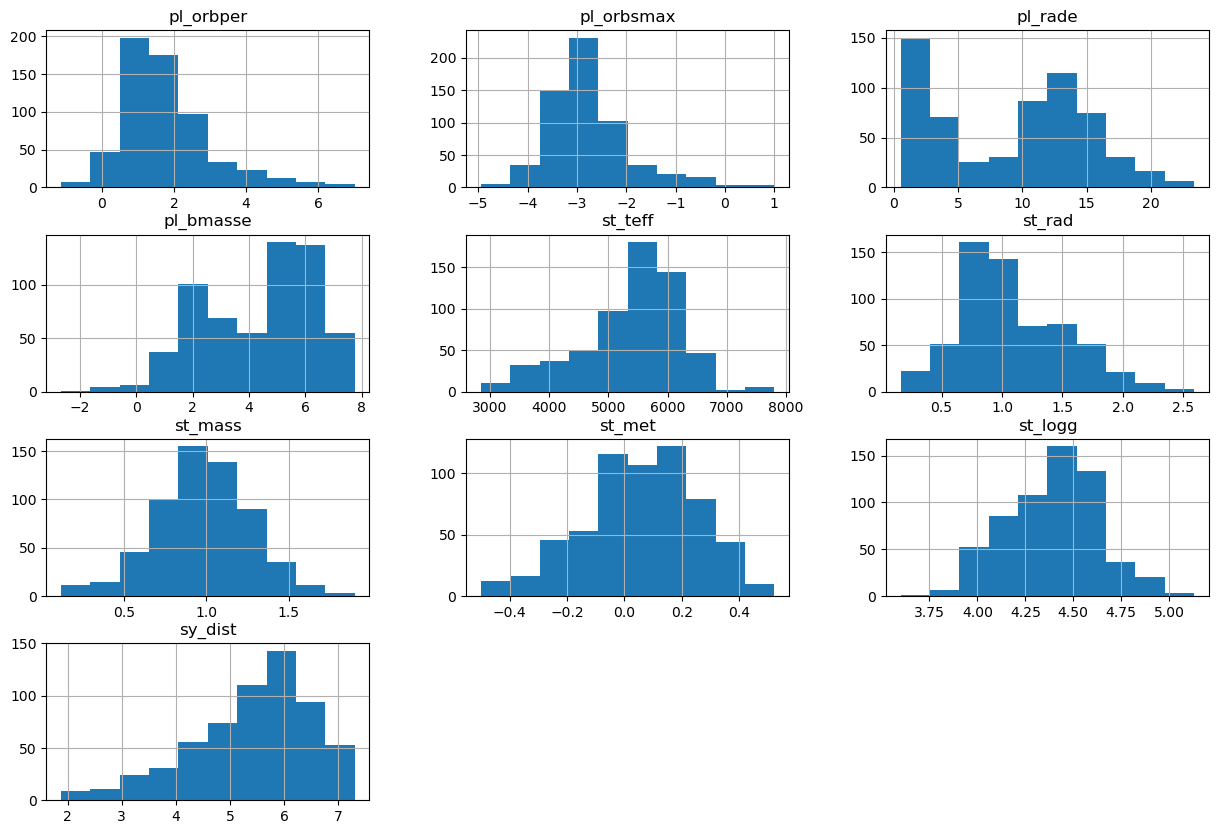

In [47]:
log_cluster_data_X.hist(bins=10, figsize=(15, 10));

### Histograms after log transformation and standardizing

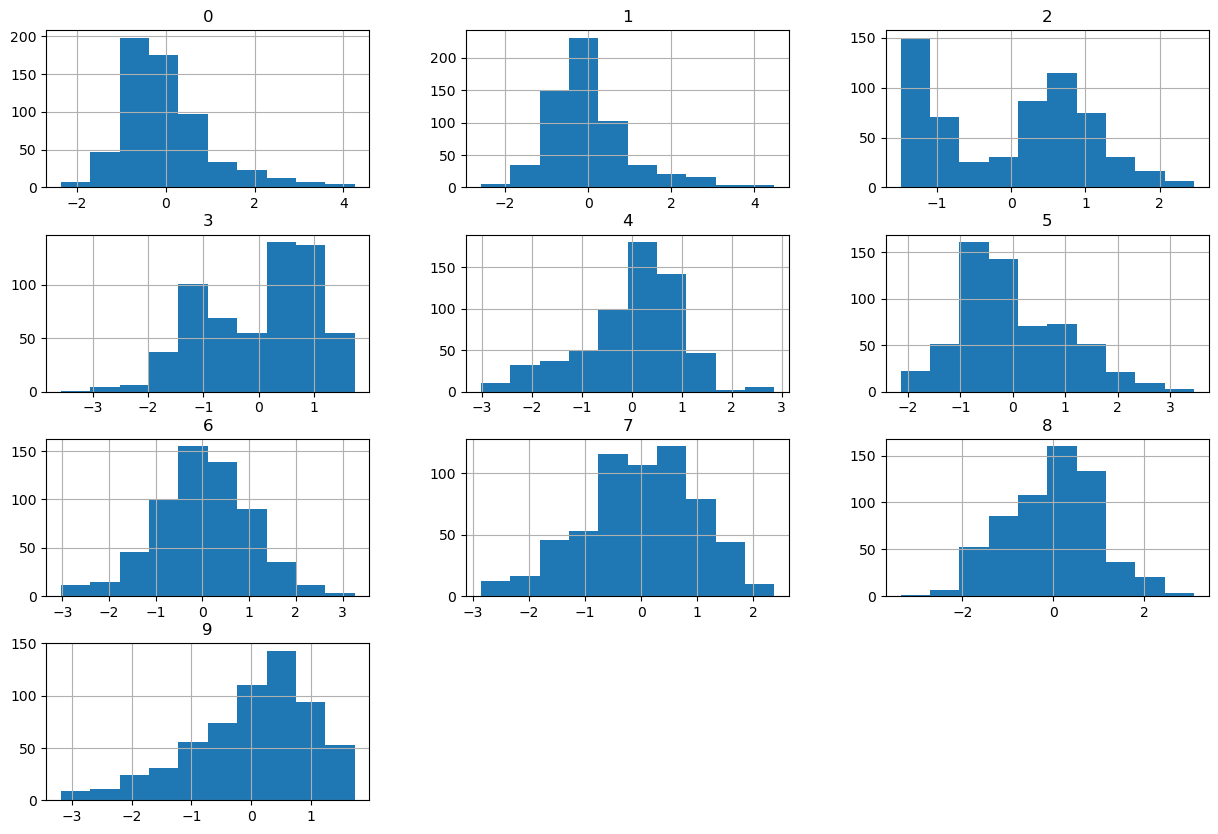

In [48]:
scaler = StandardScaler()
scaled_log_data_X = pd.DataFrame(scaler.fit_transform(log_cluster_data_X))
scaled_log_data_X.hist(bins=10, figsize=(15, 10));

In [49]:
scaled_log_data_X.describe()

0             1             2             3             4  \
count  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02   
mean  -4.495944e-17 -4.342715e-16  4.760196e-16  2.954478e-17  2.385603e-17   
std    1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00   
min   -2.358420e+00 -2.582048e+00 -1.493292e+00 -3.574013e+00 -3.024137e+00   
25%   -5.799825e-01 -5.854528e-01 -1.084510e+00 -9.096008e-01 -4.896269e-01   
50%   -2.674658e-01 -2.158564e-01  2.821379e-01  3.036930e-01  2.048407e-01   
75%    4.538272e-01  4.376578e-01  7.714637e-01  7.712169e-01  6.891873e-01   
max    4.251947e+00  4.481400e+00  2.466523e+00  1.733068e+00  2.852127e+00   

                  5             6             7             8             9  
count  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  6.050000e+02  
mean  -4.150950e-16  1.108388e-16  4.991416e-17 -3.994234e-15  3.356819e-16  
std    1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  1.000827e+00  
min   -2.141398e+00 -3.027167e+00 -2.862592e+00 -3.360047e+00 -3.177534e+00  
25%   -6.888115e-01 -5.907608e-01 -6.060395e-01 -7.400959e-01 -5.912434e-01  
50%   -2.276729e-01 -2.579690e-02  6.066922e-02  6.279220e-02  2.053030e-01  
75%    6.946044e-01  6.804079e-01  7.273779e-01  6.543940e-01  7.189973e-01  
max    3.461436e+00  3.258056e+00  2.378764e+00  3.105316e+00  1.723505e+00

# Clustering on original data

In [50]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                cluster_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

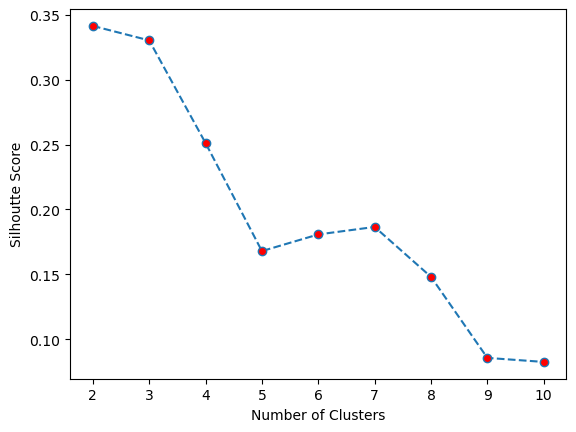

In [51]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

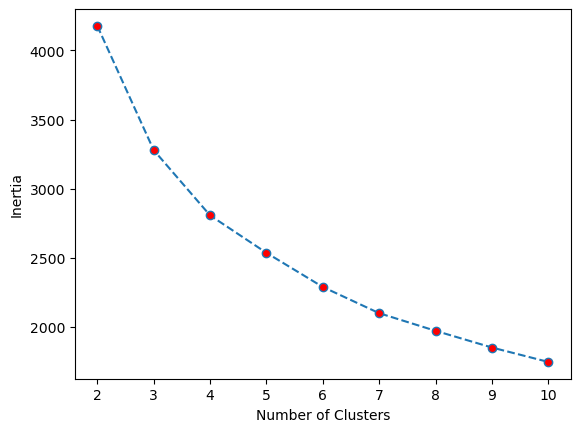

In [52]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [53]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X)

In [54]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3', 3:'Label 4'})

In [55]:
cluster_data.head()

pl_orbper  pl_orbsmax  pl_rade  pl_bmasse  st_teff  st_rad  st_mass  \
30   0.736547     0.01544    1.875      7.990   5172.0    0.94     0.91   
80  13.240600     0.10550   10.870    874.000   5075.0    0.79     0.89   
81   2.994330     0.04360   16.030    740.510   6440.0    1.37     1.27   
82   2.828042     0.04016   16.140    291.438   5675.0    1.12     1.08   
83   4.035190     0.05100    9.920    415.704   5945.0    1.01     1.09   

    st_met  st_logg    sy_dist  planet_type cluster_labels  
30    0.35     4.43    12.5855  Super Earth        Label 2  
80    0.26     4.65   338.3860    Gas Giant        Label 2  
81   -0.03     4.22   655.0370    Gas Giant        Label 1  
82    0.16     4.38  1126.3700    Gas Giant        Label 1  
83    0.01     4.46  1148.9300    Gas Giant        Label 1

In [56]:
cluster_data.cluster_labels.value_counts()

Label 1    309
Label 2    291
Label 3      5
Name: cluster_labels, dtype: int64

In [57]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

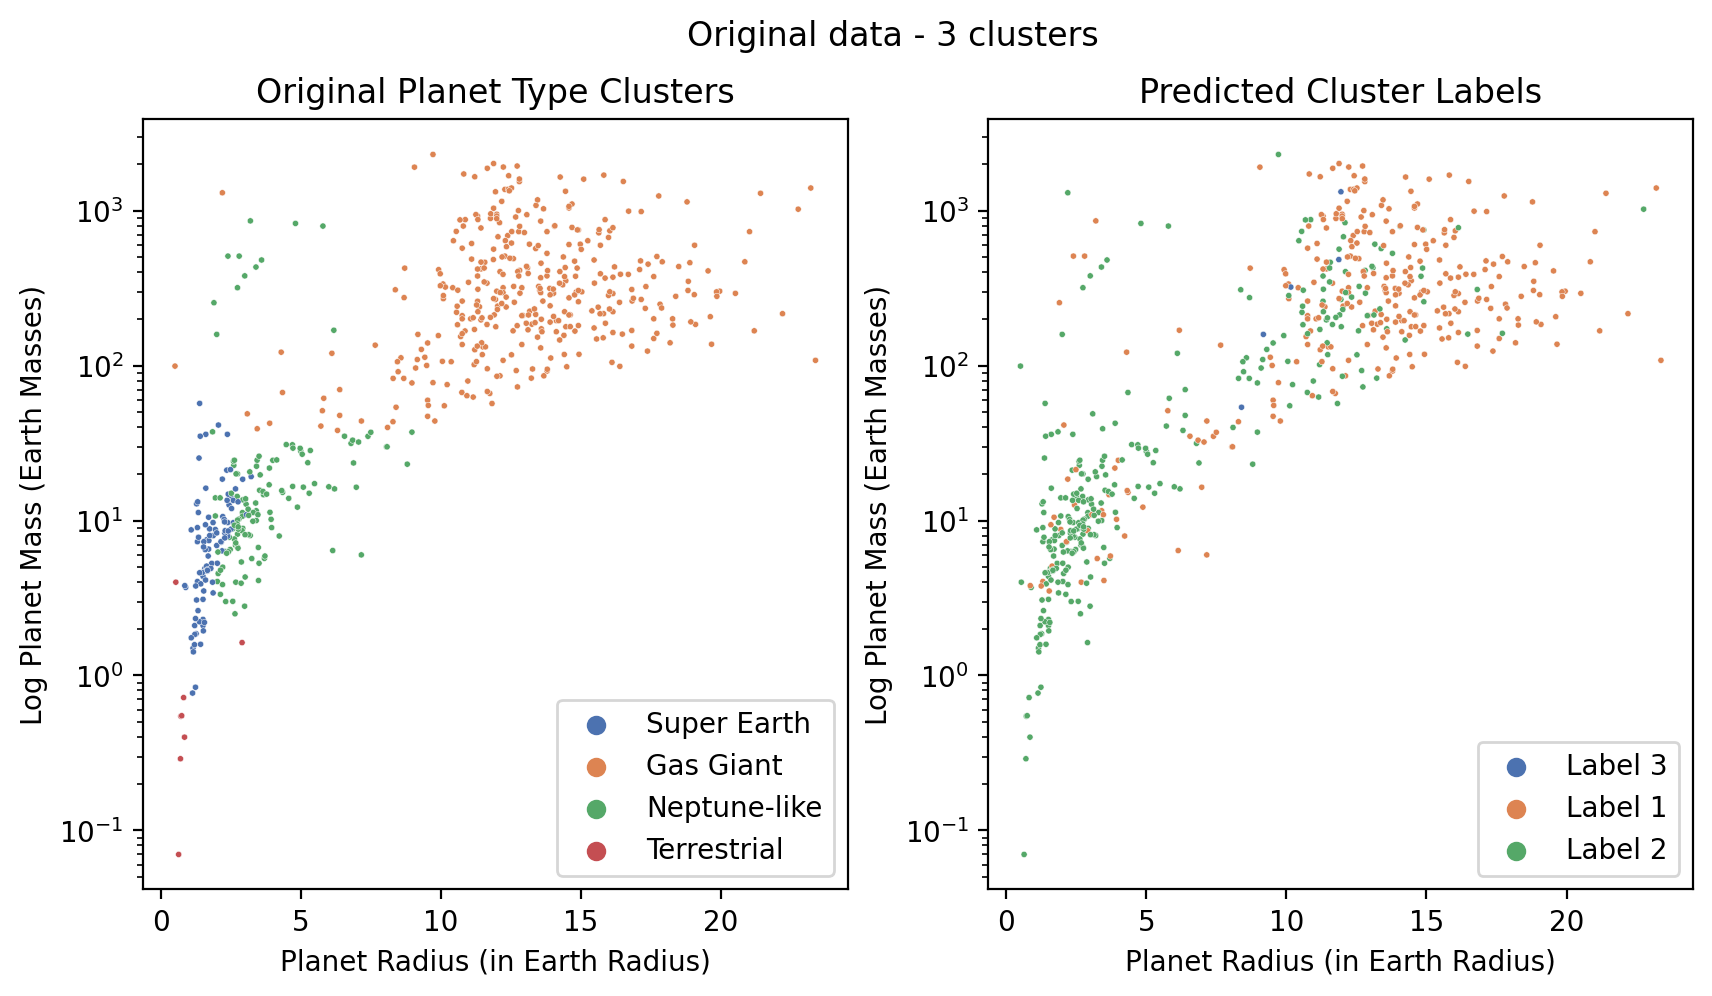

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Original data - 3 clusters')
ax1.set_title('Original Planet Type Clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

# Clustering on log transformed data

In [59]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(log_cluster_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                log_cluster_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

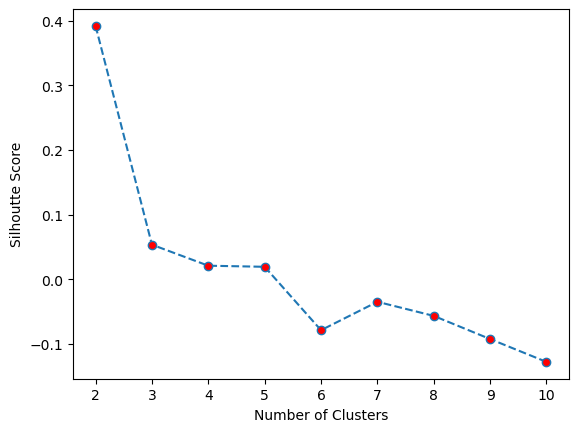

In [60]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

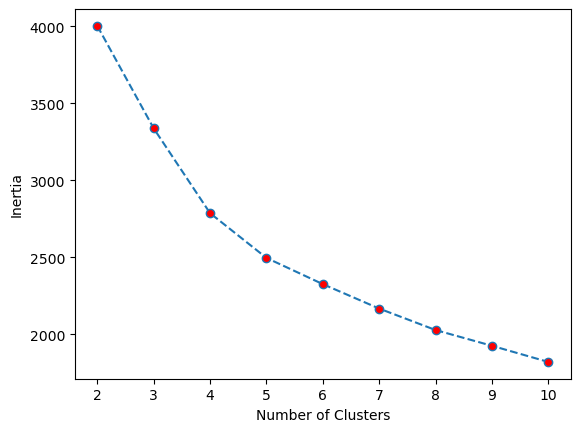

In [61]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [62]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(log_cluster_data_X)

In [63]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3',3:'Label 4'})

In [64]:
cluster_data.head()

pl_orbper  pl_orbsmax  pl_rade  pl_bmasse  st_teff  st_rad  st_mass  \
30   0.736547     0.01544    1.875      7.990   5172.0    0.94     0.91   
80  13.240600     0.10550   10.870    874.000   5075.0    0.79     0.89   
81   2.994330     0.04360   16.030    740.510   6440.0    1.37     1.27   
82   2.828042     0.04016   16.140    291.438   5675.0    1.12     1.08   
83   4.035190     0.05100    9.920    415.704   5945.0    1.01     1.09   

    st_met  st_logg    sy_dist  planet_type cluster_labels  
30    0.35     4.43    12.5855  Super Earth        Label 3  
80    0.26     4.65   338.3860    Gas Giant        Label 1  
81   -0.03     4.22   655.0370    Gas Giant        Label 1  
82    0.16     4.38  1126.3700    Gas Giant        Label 1  
83    0.01     4.46  1148.9300    Gas Giant        Label 1

In [65]:
cluster_data.cluster_labels.value_counts()

Label 1    297
Label 3    203
Label 2    105
Name: cluster_labels, dtype: int64

In [66]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

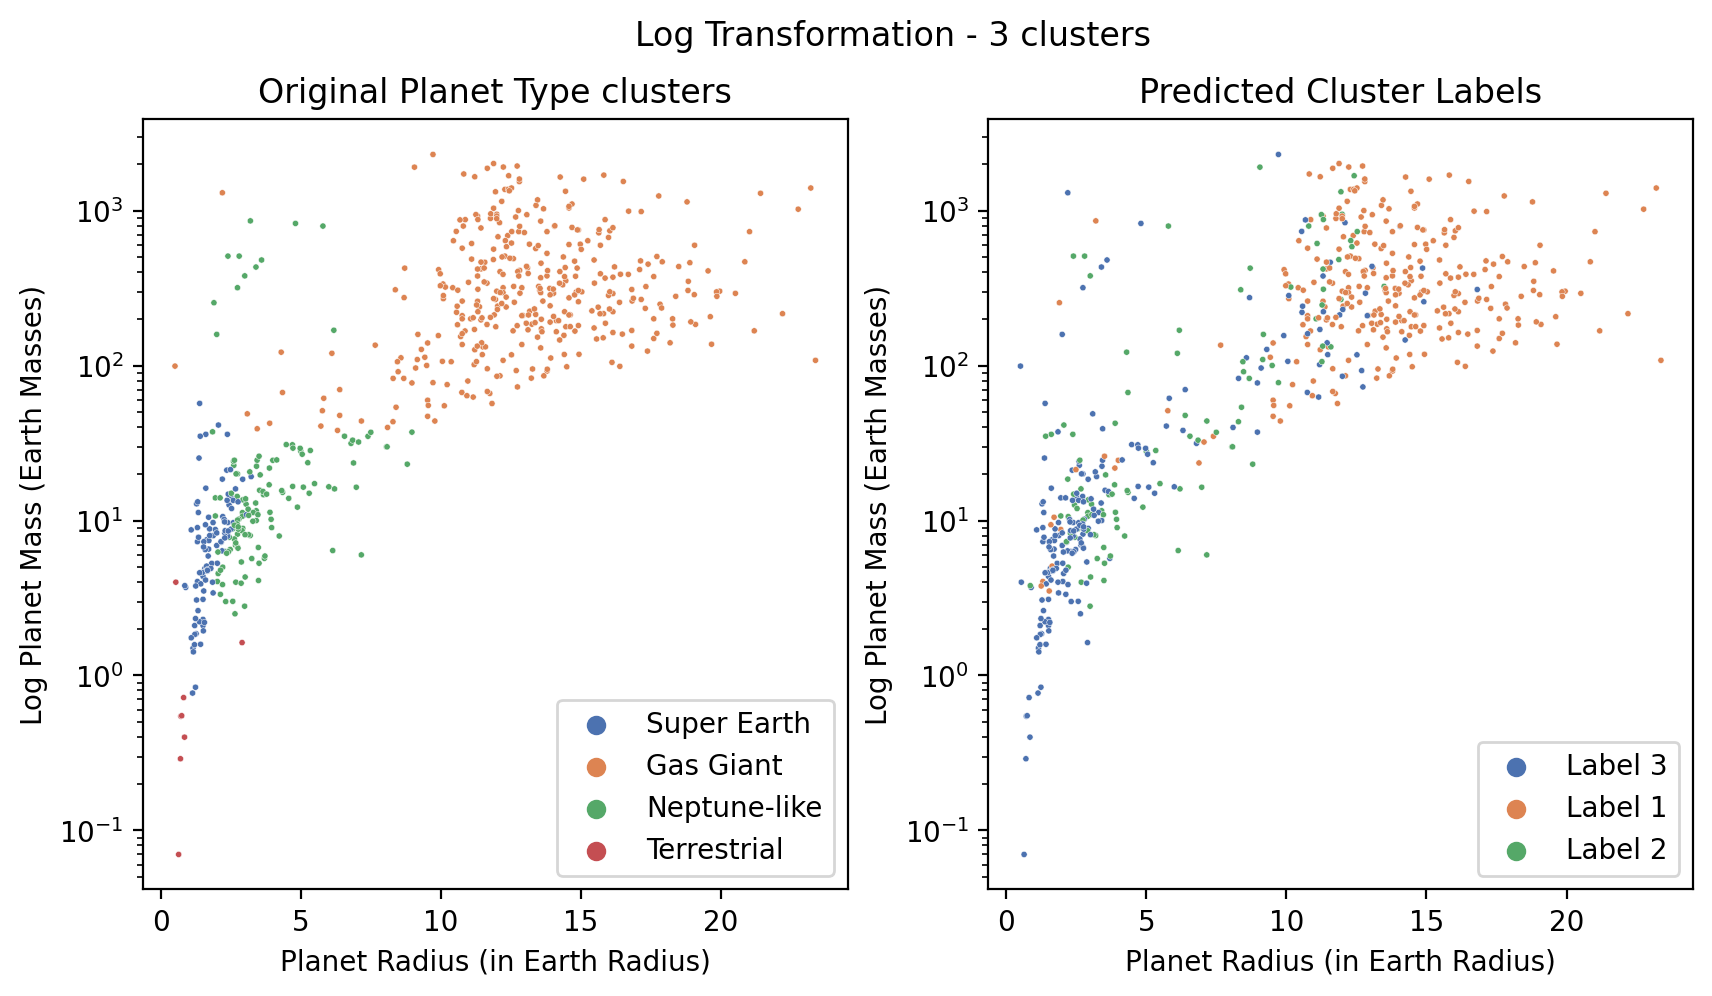

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Log Transformation - 3 clusters')
ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

# Clustering on PCA transformed data

In [68]:
pca = PCA()
pca.fit(scaled_log_data_X);

In [69]:
pca.explained_variance_ratio_

array([4.99355795e-01, 2.18532716e-01, 1.02789608e-01, 8.27647604e-02,
       4.45126925e-02, 2.72955326e-02, 1.62378671e-02, 6.28005780e-03,
       2.05277234e-03, 1.78197206e-04])

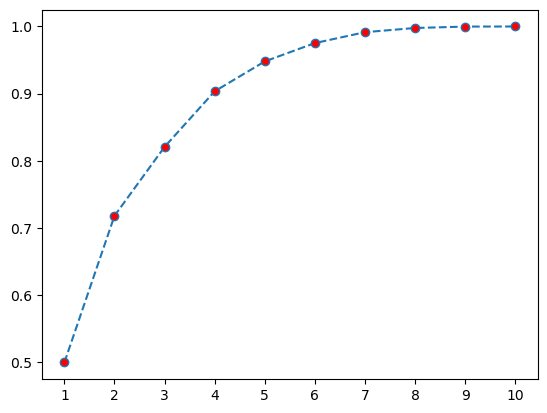

In [70]:
fig, ax = plt.subplots()
labels = list(range(1,11))
plt.plot(range(1,11),pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--',markerfacecolor='red')
ax.set_xticks(labels);

In [71]:
pca = PCA(n_components=3)
pca_data_X = pca.fit_transform(scaled_log_data_X);

In [72]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(kmeans).fit(pca_data_X)
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                pca_data_X,
                estimator[-1].labels_,
                metric="euclidean",
            ))

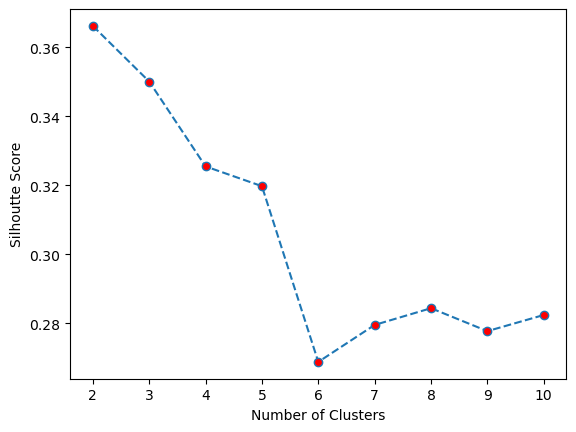

In [73]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

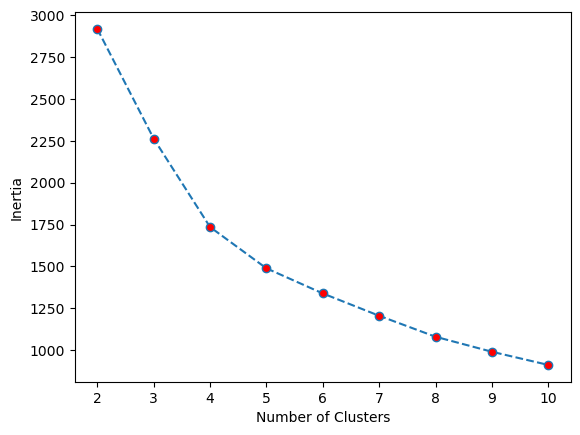

In [74]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [75]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(kmeans).fit(pca_data_X)

In [76]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3',3:'Label 4'})
cluster_data[['component_1','component_2','component_3']] = pca_data_X

In [77]:
cluster_data.head()

pl_orbper  pl_orbsmax  pl_rade  pl_bmasse  st_teff  st_rad  st_mass  \
30   0.736547     0.01544    1.875      7.990   5172.0    0.94     0.91   
80  13.240600     0.10550   10.870    874.000   5075.0    0.79     0.89   
81   2.994330     0.04360   16.030    740.510   6440.0    1.37     1.27   
82   2.828042     0.04016   16.140    291.438   5675.0    1.12     1.08   
83   4.035190     0.05100    9.920    415.704   5945.0    1.01     1.09   

    st_met  st_logg    sy_dist  planet_type cluster_labels  component_1  \
30    0.35     4.43    12.5855  Super Earth        Label 2     1.953445   
80    0.26     4.65   338.3860    Gas Giant        Label 3     0.200991   
81   -0.03     4.22   655.0370    Gas Giant        Label 1    -2.511367   
82    0.16     4.38  1126.3700    Gas Giant        Label 1    -1.509425   
83    0.01     4.46  1148.9300    Gas Giant        Label 1    -1.026970   

    component_2  component_3  
30    -1.967731     1.070381  
80     0.083682    -2.248161  
81    -0.741866     0.382479  
82    -1.201108    -0.732628  
83    -0.492228    -0.334984

In [78]:
cluster_data.cluster_labels.value_counts()

Label 1    289
Label 2    210
Label 3    106
Name: cluster_labels, dtype: int64

In [79]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

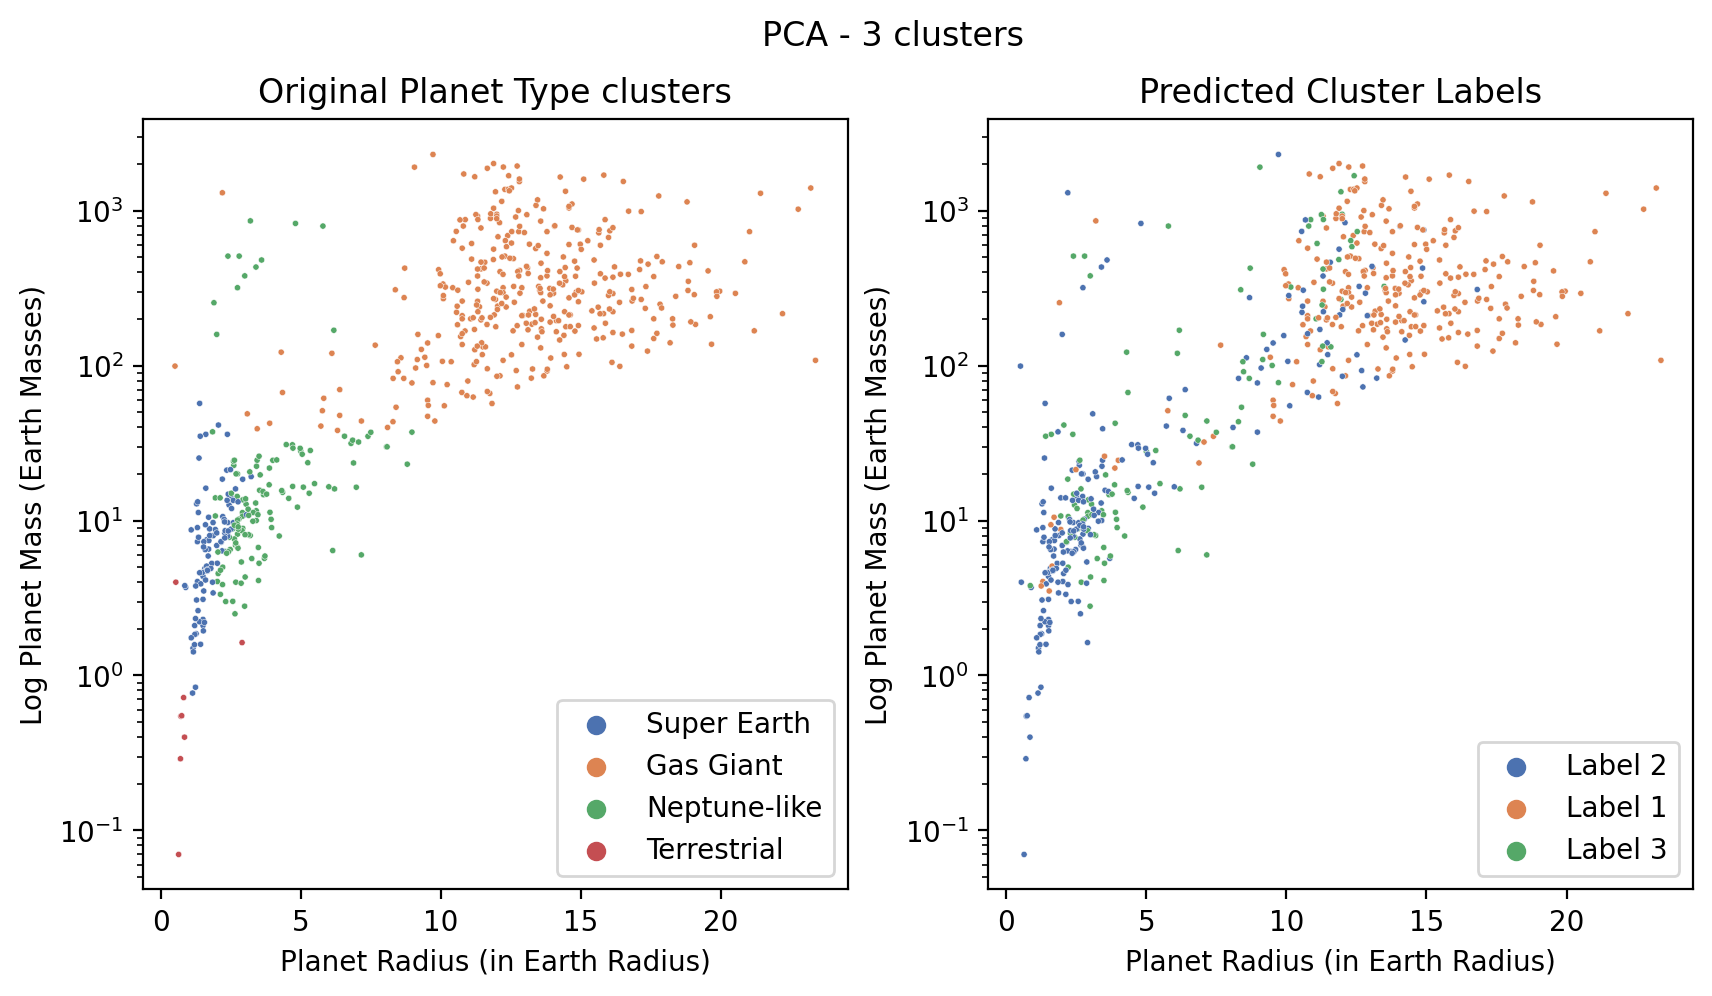

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('PCA - 3 clusters')
ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 2','Label 1','Label 3'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();

In [81]:
scaled_log_data_X.columns = cluster_data.columns.values[0:10]

In [82]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter_3d(cluster_data, x='component_1', y='component_2', z='component_3', color='cluster_labels')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)

fig.show()

In [83]:
loadings

array([[ 0.01617701,  0.95763132, -0.27558817],
       [-0.11027836,  0.9590585 , -0.25296216],
       [-0.7671372 , -0.34613011, -0.22179624],
       [-0.70411343, -0.28202171, -0.43096795],
       [-0.89076579,  0.14558856,  0.23691243],
       [-0.91026685,  0.13202401,  0.24998504],
       [-0.93860048,  0.09509377,  0.16448609],
       [-0.27832869, -0.28093446, -0.61678898],
       [ 0.86939474, -0.15836527, -0.28073136],
       [-0.75418358, -0.03284941, -0.22319906]])

In [84]:
loadings_df = pd.DataFrame(loadings)
loadings_df.index = scaled_log_data_X.columns
loadings_df

0         1         2
pl_orbper   0.016177  0.957631 -0.275588
pl_orbsmax -0.110278  0.959058 -0.252962
pl_rade    -0.767137 -0.346130 -0.221796
pl_bmasse  -0.704113 -0.282022 -0.430968
st_teff    -0.890766  0.145589  0.236912
st_rad     -0.910267  0.132024  0.249985
st_mass    -0.938600  0.095094  0.164486
st_met     -0.278329 -0.280934 -0.616789
st_logg     0.869395 -0.158365 -0.280731
sy_dist    -0.754184 -0.032849 -0.223199

In [85]:
viz_features = {0:'pl_orbper', 2:'pl_rade', 3:'pl_bmasse', 9:'sy_dist'}
fig = px.scatter(cluster_data, x='component_1', y='component_2', color='cluster_labels')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)

for i, feature in viz_features.items():
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y", 
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0, 
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )

fig.show()

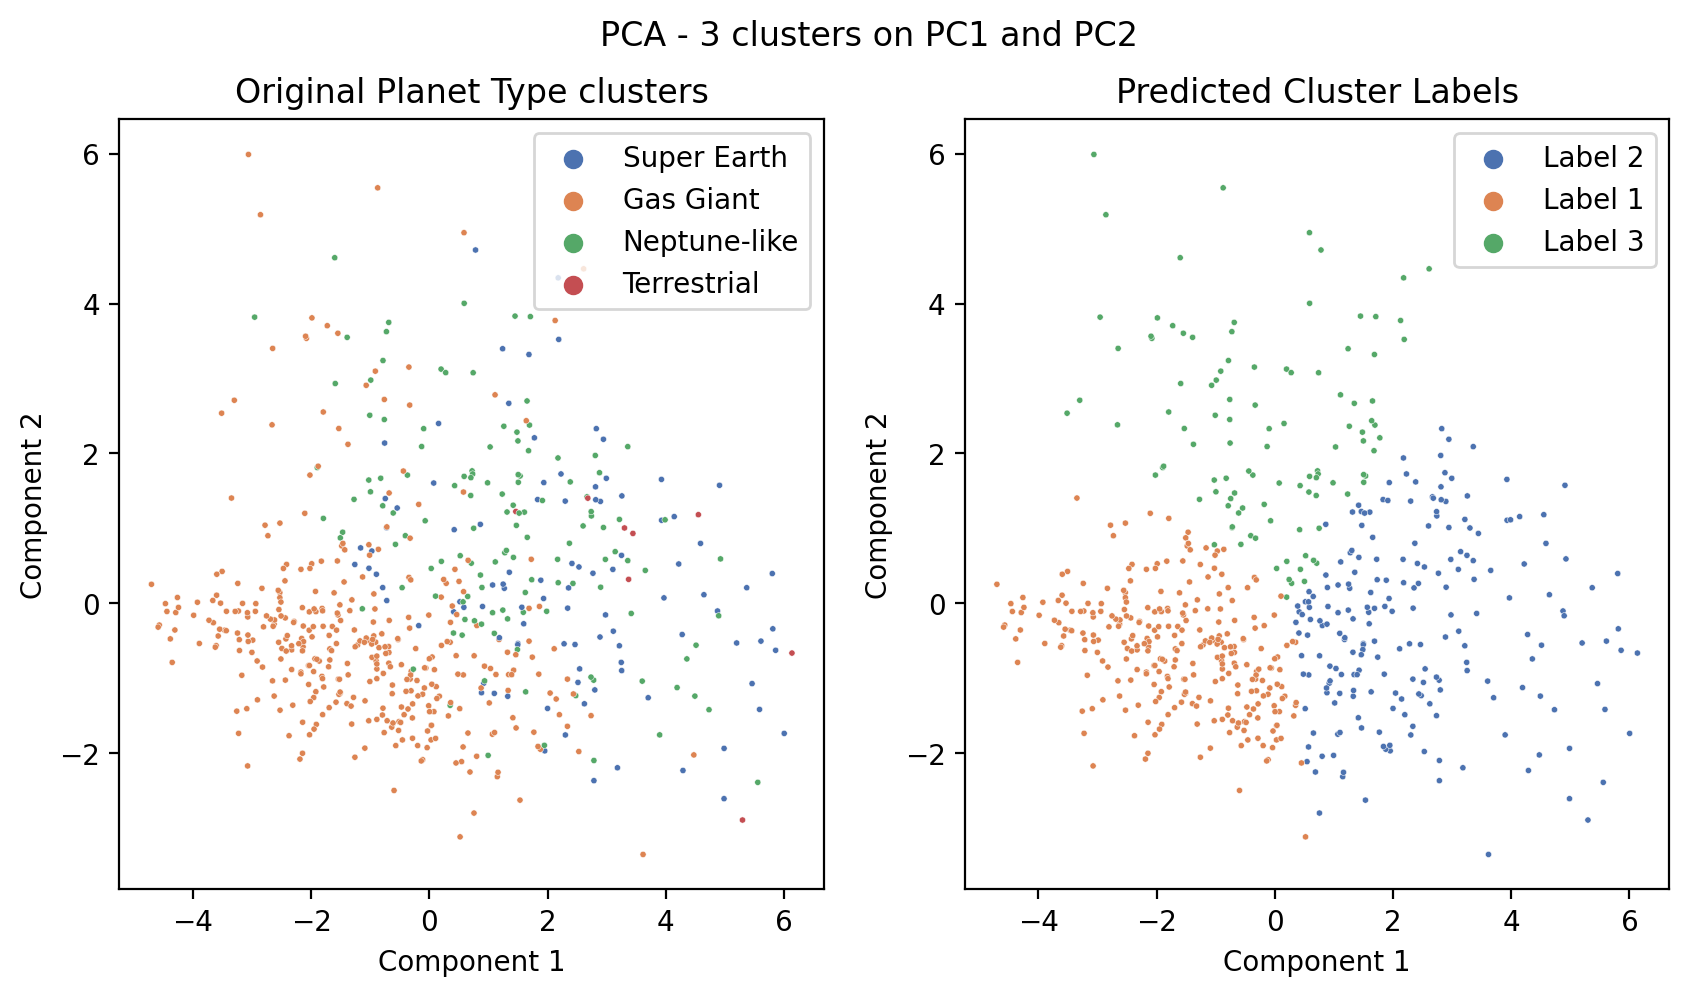

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('PCA - 3 clusters on PC1 and PC2')
ax1.set_title('Original Planet Type clusters')
sns.scatterplot(data=cluster_data, x='component_1', y='component_2', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='component_1', y='component_2', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 2','Label 1','Label 3'])
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.legend();

# Clustering on subset of features

In [319]:
subset_features = ['pl_rade','pl_bmasse','pl_orbper']

In [320]:
silhoutte_score = []
inertia = []
min_clusters = 2
max_clusters = 11

for i in range(min_clusters,max_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=i, random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X.loc[:,subset_features])
    inertia.append(estimator[-1].inertia_)
    silhoutte_score.append(metrics.silhouette_score(
                cluster_data_X.loc[:,subset_features],
                estimator[-1].labels_,
                metric="euclidean",
            ))

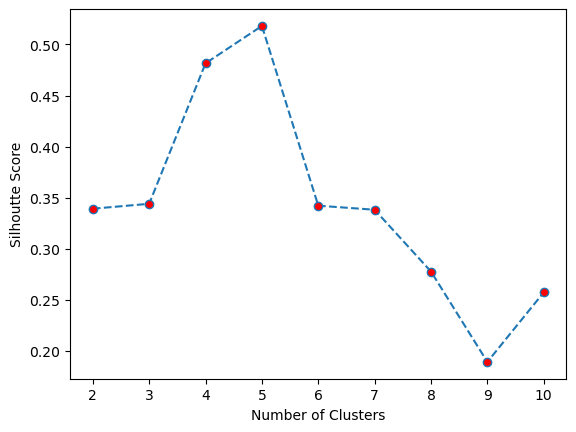

In [321]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(silhoutte_score,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhoutte Score')
ax.set_xticklabels(labels);

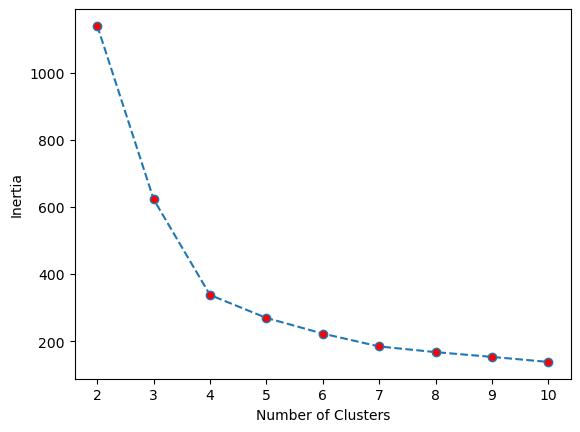

In [322]:
fig,ax = plt.subplots()

labels = list(range(min_clusters-1,max_clusters))

plt.plot(inertia,marker='o',markerfacecolor='red',linestyle='--')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_xticklabels(labels);

In [323]:
best_clusters = 3

kmeans = KMeans(init="k-means++", n_clusters=best_clusters, random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans).fit(cluster_data_X.loc[:,subset_features])

In [324]:
cluster_data['cluster_labels'] = estimator[-1].labels_
cluster_data['cluster_labels'] = cluster_data['cluster_labels'].map({0:'Label 1',1:'Label 2', 2:'Label 3', 3:'Label 4'})

In [325]:
cluster_data.head()

pl_orbper  pl_orbsmax  pl_rade  pl_bmasse  st_teff  st_rad  st_mass  \
30   0.736547     0.01544    1.875      7.990   5172.0    0.94     0.91   
80  13.240600     0.10550   10.870    874.000   5075.0    0.79     0.89   
81   2.994330     0.04360   16.030    740.510   6440.0    1.37     1.27   
82   2.828042     0.04016   16.140    291.438   5675.0    1.12     1.08   
83   4.035190     0.05100    9.920    415.704   5945.0    1.01     1.09   

    st_met  st_logg    sy_dist  planet_type cluster_labels  component_1  \
30    0.35     4.43    12.5855  Super Earth        Label 2     1.953445   
80    0.26     4.65   338.3860    Gas Giant        Label 1     0.200991   
81   -0.03     4.22   655.0370    Gas Giant        Label 1    -2.511367   
82    0.16     4.38  1126.3700    Gas Giant        Label 1    -1.509425   
83    0.01     4.46  1148.9300    Gas Giant        Label 1    -1.026970   

    component_2  component_3  
30    -1.967731     1.070381  
80     0.083682    -2.248161  
81    -0.741866     0.382479  
82    -1.201108    -0.732628  
83    -0.492228    -0.334984

In [326]:
cluster_data.cluster_labels.value_counts()

Label 1    329
Label 2    271
Label 3      5
Name: cluster_labels, dtype: int64

In [327]:
cluster_data.planet_type.value_counts()

Gas Giant       368
Neptune-like    129
Super Earth     100
Terrestrial       8
Name: planet_type, dtype: int64

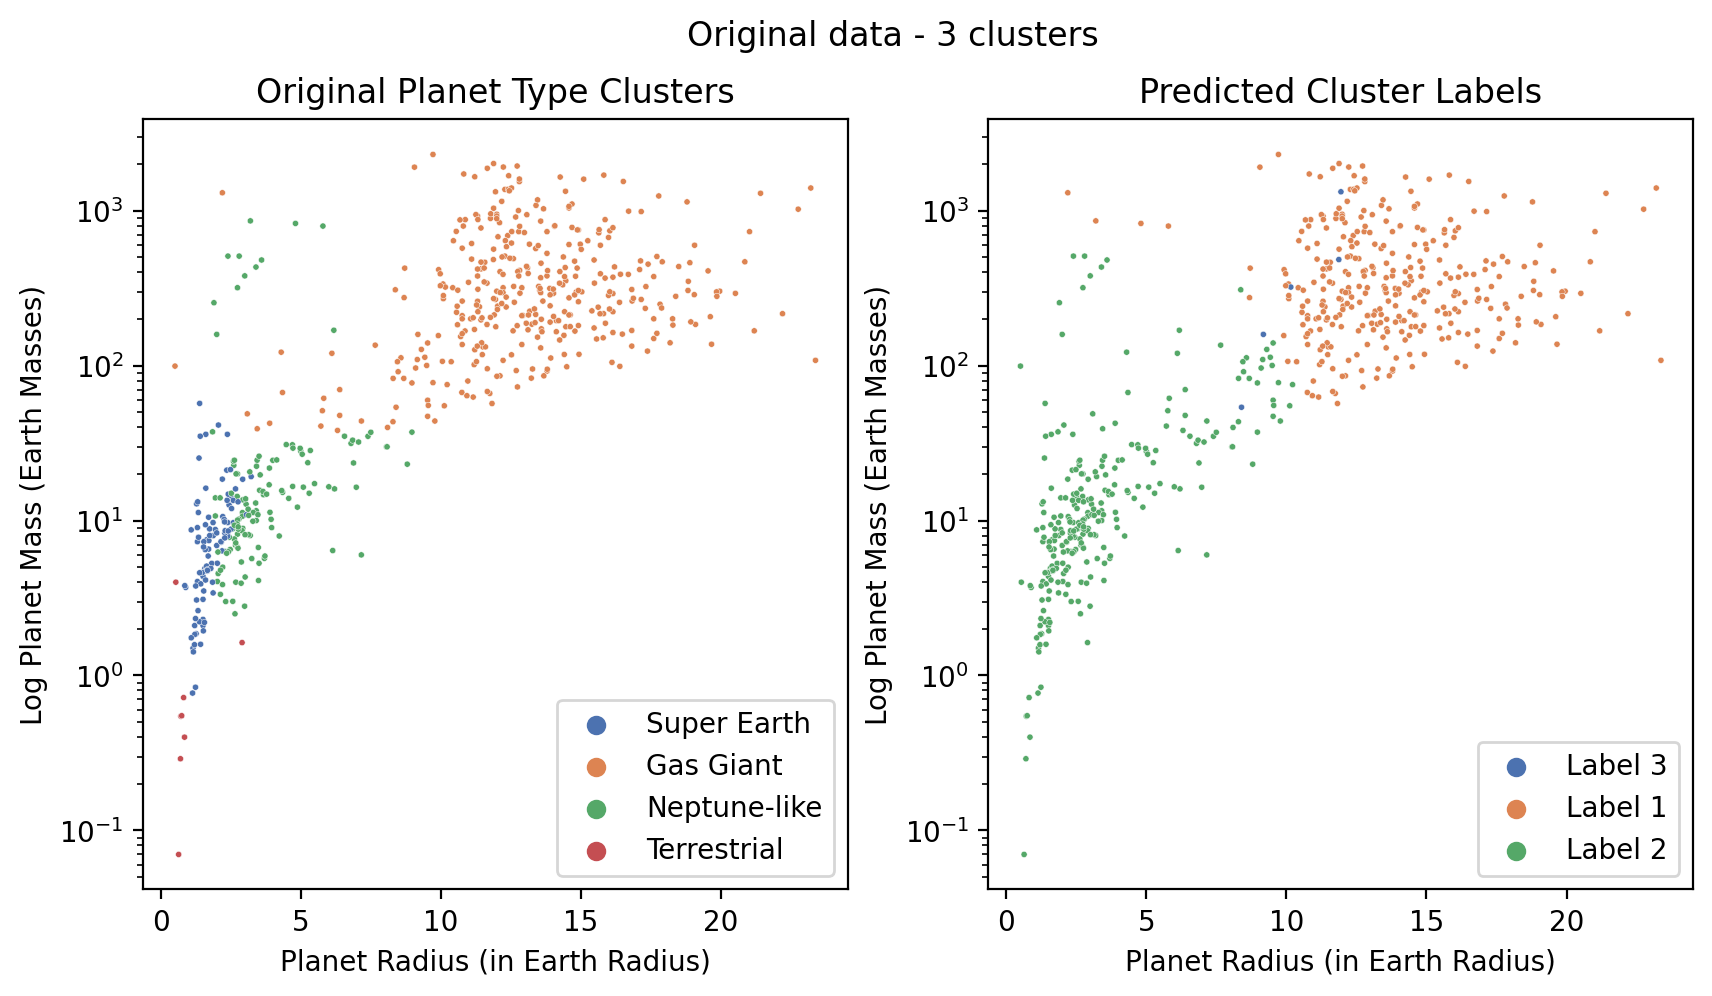

In [328]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=200)
fig.suptitle('Original data - 3 clusters')
ax1.set_title('Original Planet Type Clusters')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='planet_type', ax=ax1, s=5, palette="deep")
ax1.set_yscale('log')
ax1.set_xlabel('Planet Radius (in Earth Radius)')
ax1.set_ylabel('Log Planet Mass (Earth Masses)')
ax1.legend()

ax2.set_title('Predicted Cluster Labels')
sns.scatterplot(data=cluster_data, x='pl_rade', y='pl_bmasse', hue='cluster_labels', ax=ax2, s=5, palette="deep", hue_order=['Label 3','Label 1','Label 2'])
ax2.set_yscale('log')
ax2.set_xlabel('Planet Radius (in Earth Radius)')
ax2.set_ylabel('Log Planet Mass (Earth Masses)')
ax2.legend();